In [45]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""
This notebook demonstrates how to read data from the Toggl API and do some simple analysis. 
Written by Stefan Kussmaul, https://www.stefanonsoftware.com.
"""
import api
import matplotlib.pyplot as plt
from datetime import date, datetime

# Enter your Toggl email and password here.
TOGGL_EMAIL = r''
TOGGL_PASSWORD = r''

_api = api.TogglApi(TOGGL_EMAIL, TOGGL_PASSWORD)

In [40]:
# Call the `me` endpoint and get the default workspace ID.
my_data = _api.me()
WORKSPACE_ID = my_data['default_workspace_id']
print(f"Default workspace_id is {WORKSPACE_ID}.")

Default workspace_id is 5684519.


In [41]:
# Load project data.
projects = _api.project_data(WORKSPACE_ID)
print(f"Loaded data for {len(projects)} projects.")

Loaded data for 14 projects.


In [33]:
# Calculate the sum of hours tracked.
print(f"You tracked a total of {sum(p.actual_hours for p in projects)} hours.")

# Sort projects by time spent.
projects.sort(key=lambda p: p.actual_hours, reverse=True)
print('\n'.join(f"{p.name}: {p.actual_hours} hours" for p in projects))

You tracked a total of 2216 hours.
Master's Thesis: 476 hours
Personal Projects: 379 hours
Sport: 370 hours
Career: 217 hours
QPLIX: 213 hours
Other Uni: 124 hours
Data Engineering: 114 hours
Guitar: 110 hours
AI: 92 hours
Blog-Projects: 36 hours
Google: 31 hours
Distributed Systems: 23 hours
Reading: 17 hours
DB Implementation: 14 hours


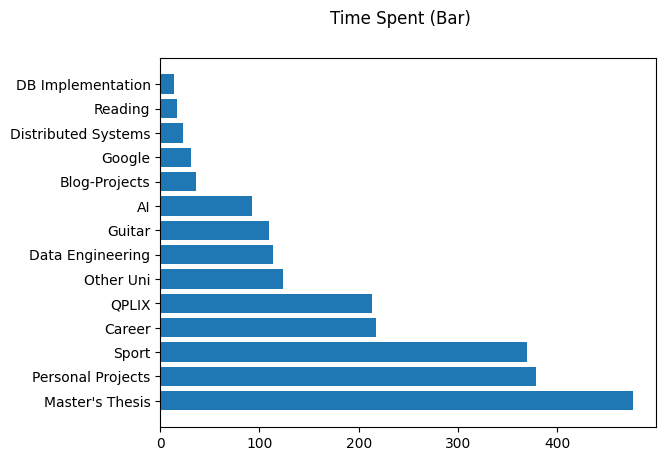

In [34]:
# Make a simple bar plot of projects by time spent.
# Note: adding a semicolon ";" at the end of the plot statement hides the annoying text that the notebook would normally print.
fig, ax = plt.subplots()
fig.suptitle('Time Spent (Bar)')
ax.barh(
    [p.name for p in projects],
    [p.actual_hours for p in projects],
);

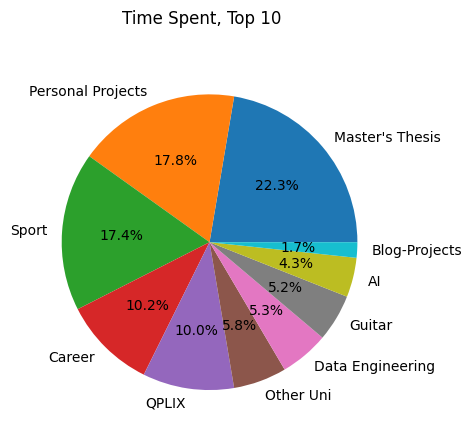

In [35]:
# Make a pie plot of the top 10 projects.
# If there are fewer than 10 projects, limit to the number of projects we have.
n = min(10, len(projects))

fig, ax = plt.subplots()
fig.suptitle(f"Time Spent, Top {n}")
ax.pie(
    [p.actual_hours for p in projects[:n]],
    labels=[p.name for p in projects[:n]],
    autopct="%1.1f%%",
);

In [36]:
# Load all tracked time entries from the past three months.
# This is the maximum amount of time that the Toggl TimeEntry API supports.
from dateutil.relativedelta import relativedelta
start_date = (datetime.now() - relativedelta(months=3)).date()
end_date = datetime.now().date()

time_entries = _api.time_entries(start_date, end_date)
print(f"Loaded {len(time_entries)} time entries between {start_date} and {end_date}.")

Loaded 109 time entries between 2023-06-17 and 2023-09-17.


In [44]:
import statistics
from IPython.display import Markdown

def format_seconds(sec: int) -> str:
    """Returns a human-readable string describing the number of hours
    and minutes that make up the given number of seconds."""
    hours = int(sec // 3600)
    minutes = (sec - hours * 3600) // 60  
    return f'{hours} hours {minutes} minutes'
    

# Create a mapping of project ID to project name.
project_names = {p.id: p.name for p in projects}

# Generate a Markdown table with some basic statistics.
table = "| Project | Num Entries | Time Spent | Avg. Duration |\n"
table += "| --- | --- | --- | --- |\n"
for project_id, project_name in project_names.items():
    # Get a list of time entries that match `project_id`.
    project_entries = list(filter(lambda t: (t.project_id == project_id), time_entries))
    time_spent = sum(t.duration for t in project_entries)
    avg_duration = int(statistics.mean(t.duration for t in project_entries)) if project_entries else 0
    table += f"| {project_name} | {len(project_entries)} | {format_seconds(time_spent)} | {format_seconds(avg_duration)} |\n"

Markdown(table)

| Project | Num Entries | Time Spent | Avg. Duration |
| --- | --- | --- | --- |
| AI | 0 | 0 hours 0 minutes | 0 hours 0 minutes |
| Blog-Projects | 3 | 3 hours 0 minutes | 1 hours 0 minutes |
| Career | 0 | 0 hours 0 minutes | 0 hours 0 minutes |
| Data Engineering | 0 | 0 hours 0 minutes | 0 hours 0 minutes |
| DB Implementation | 0 | 0 hours 0 minutes | 0 hours 0 minutes |
| Distributed Systems | 0 | 0 hours 0 minutes | 0 hours 0 minutes |
| Google | 0 | 0 hours 0 minutes | 0 hours 0 minutes |
| Guitar | 14 | 9 hours 0 minutes | 0 hours 38 minutes |
| Master's Thesis | 0 | 0 hours 0 minutes | 0 hours 0 minutes |
| Other Uni | 0 | 0 hours 0 minutes | 0 hours 0 minutes |
| Personal Projects | 32 | 36 hours 30 minutes | 1 hours 8 minutes |
| QPLIX | 0 | 0 hours 0 minutes | 0 hours 0 minutes |
| Reading | 0 | 0 hours 0 minutes | 0 hours 0 minutes |
| Sport | 60 | 52 hours 45 minutes | 0 hours 52 minutes |
